# Cybersecurity Anomaly Detection using K-Means Clustering with Network Traffic Features

- Author: Sebastian Schuetz, swschuetz@outlook.com
- Date: Feb 12, 2025

## 1. Introduction
In network security, anomalies in traffic patterns can indicate potential intrusions or malicious behavior. In this exercise, you will:
- Load the CSV file for further analysis.
- Explore and preprocess the data.
- Use the elbow method to determine the optimal number of clusters.
- Apply K-Means clustering to group similar network behavior.
- Compute distances from cluster centers to flag potential anomalies.
- Compare the clustering-based anomaly predictions with our known (simulated) anomaly labels.


## 2. Load Data for Analysis

In [2]:
# Load the dataset from the CSV file
df_loaded = pd.read_csv(csv_filename)
df_loaded.head()

,packet_size,connection_duration,num_packets,inter_arrival_time,is_anomaly
0,48.829233,8.829315,107.896064,23.837174,0
1,47.644808,11.160250,92.759578,12.962681,0
2,66.484973,14.885660,115.003489,19.476125,0
3,64.674432,18.473876,146.952439,24.065143,0
4,59.025459,20.668850,122.967784,7.298057,0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.metrics import confusion_matrix, classification_report

# For reproducibility
np.random.seed(42)

# Number of samples
n_samples_normal = 500
n_samples_anomaly = 20

# Define centers for 3 clusters in 4 dimensions
centers = [[50, 10, 100, 20], [70, 20, 150, 25], [60, 15, 120, 22]]
cluster_std = 5  # Controls spread within each cluster

# Generate synthetic normal network traffic data
X_normal, _ = make_blobs(n_samples=n_samples_normal, centers=centers, 
                         cluster_std=cluster_std, n_features=4, random_state=42)

# Generate synthetic anomalies (e.g., abnormal network behavior)
X_anomaly = np.random.uniform(low=20, high=100, size=(n_samples_anomaly, 4))
# Optionally, shift the anomalies further away:
X_anomaly = X_anomaly + np.random.uniform(low=15, high=30, size=(n_samples_anomaly, 4))

# Combine the data into one dataset
X_combined = np.vstack([X_normal, X_anomaly])

# Create a DataFrame with appropriate feature names
columns = ['packet_size', 'connection_duration', 'num_packets', 'inter_arrival_time']
df = pd.DataFrame(X_combined, columns=columns)

# For evaluation purposes, mark anomalies (0 = normal, 1 = anomaly)
df['is_anomaly'] = 0
df.loc[n_samples_normal:, 'is_anomaly'] = 1

df_loaded = df

## 3. Exploratory Data Analysis (EDA)
Next, we explore the data using boxplots. 

Note: Boxplots analyze one feature at a time and do not consider the relationships between multiple features. In multivariate datasets, an observation might be unremarkable in each individual feature yet be anomalous when considering the combination of features. Furthermore, boxplots use the 1.5×IQR rule to identify outliers. This, however, is a heuristic—it might be too strict or too lenient depending on the distribution and context.

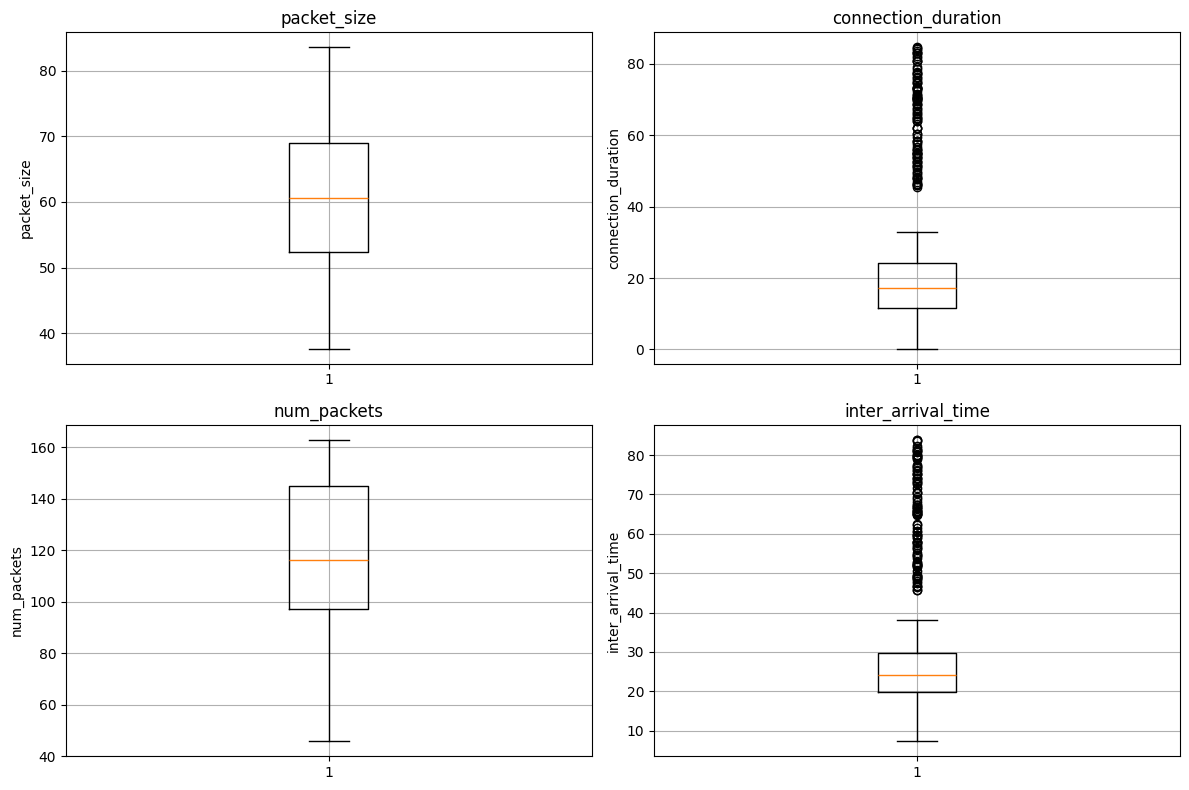

In [3]:
# List of features for boxplots
features = ['packet_size', 'connection_duration', 'num_packets', 'inter_arrival_time']

# Set up a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

for i, feature in enumerate(features):
    axes[i].boxplot(df_loaded[feature])
    axes[i].set_title(feature)
    axes[i].set_ylabel(feature)
    axes[i].grid(True)

plt.tight_layout()
plt.show()

## 4. Cluster Analysis

### 4.1 Determine the Optimal Number of Clusters (Elbow Method)

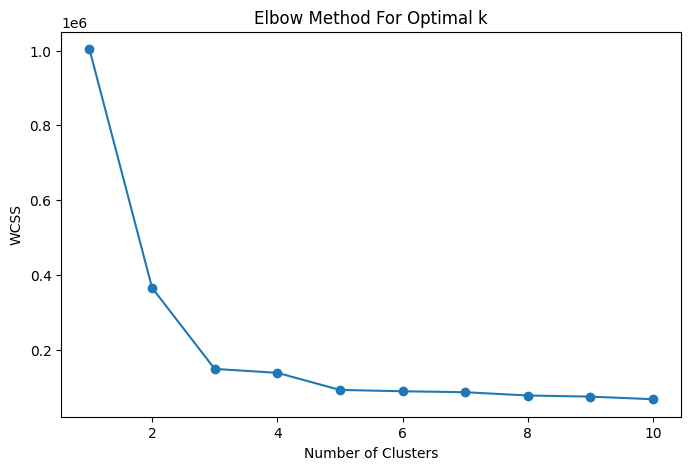

In [4]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_loaded)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method For Optimal k')
plt.show()

### 4.1 Perform K-Means Cluster Analysis
Based on the elbow plot, we observe that 3 seems to be a good number of clusters. Hence, we decide to classify the data into three (k=3) clusters.

<div style="border: 2px solid red; padding: 10px; color: red;">
<b>Experiment 1:</b> Vary the number of clusters by chaning k=2, k=5, etc. Observe how this affects the clustering results. Which clustering solution is the most useful for our purposes, i.e., identifying anomalies in network traffic?
</div>

In [5]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
df_loaded['cluster'] = kmeans.fit_predict(df_loaded[features])

Let's visualize the clusters:

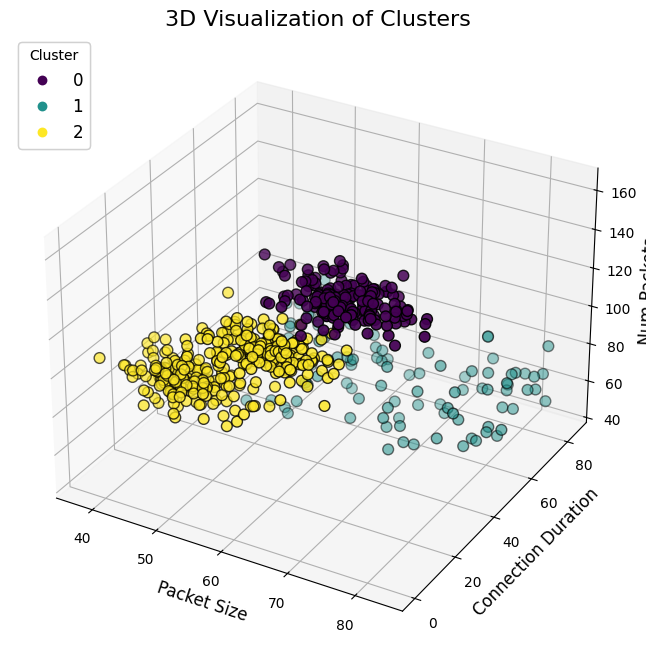

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

# Create a 3D figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create the 3D scatter plot.
# Each point's color corresponds to its cluster label.
sc = ax.scatter(df_loaded['packet_size'], 
                df_loaded['connection_duration'], 
                df_loaded['num_packets'],
                c=df_loaded['cluster'],    # Use the cluster assignments for coloring
                cmap='viridis', 
                edgecolor='k', 
                s=60)

# Set the axis labels and title
ax.set_xlabel('Packet Size', fontsize=12)
ax.set_ylabel('Connection Duration', fontsize=12)
ax.set_zlabel('Num Packets', fontsize=12)
ax.set_title('3D Visualization of Clusters', fontsize=16)

# Create a legend for the clusters
# The scatter.legend_elements() method automatically creates handles and labels for each cluster.
legend1 = ax.legend(*sc.legend_elements(), title="Cluster", loc="upper left", fontsize=12)
ax.add_artist(legend1)

plt.show()

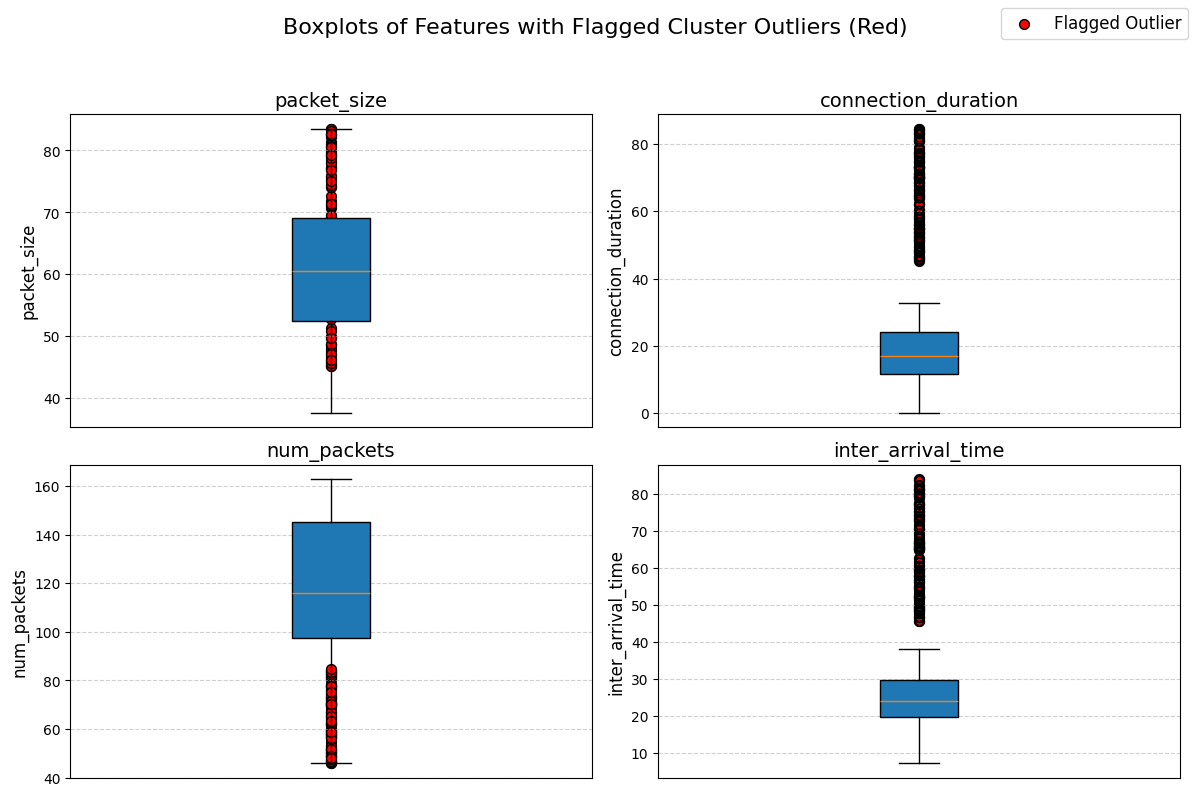

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Specify which cluster you want to flag as outliers
flag_cluster = 1

# List of features to plot
features = ['packet_size', 'connection_duration', 'num_packets', 'inter_arrival_time']

# Filter the DataFrame to get only the datapoints that belong to the flagged cluster
flagged_points = df_loaded[df_loaded['cluster'] == flag_cluster]

# Create a subplot for each feature in a 1 x 4 grid (adjust layout if needed)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

for ax, feature in zip(axes, features):
    # Create the boxplot for the entire dataset for the feature
    bp = ax.boxplot(
        df_loaded[feature],
        vert=True,
        patch_artist=True
    )
    
    # Overlay the datapoints from the flagged cluster
    # The boxplot is drawn at x=1 by default, so we plot our flagged points at x=1.
    x_values = np.ones(len(flagged_points))
    y_values = flagged_points[feature].values
    ax.scatter(
        x_values, y_values,
        color='red', edgecolors='k',
        marker='o', s=50, label='Flagged Outlier'
    )
    
    ax.set_title(feature, fontsize=14)
    ax.set_xticks([])  # Remove x-axis ticks since the boxplot is at a fixed x-position
    ax.set_ylabel(feature, fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)

# Create a single legend for the entire figure using the handles from the first subplot
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=12)

fig.suptitle("Boxplots of Features with Flagged Cluster Outliers (Red)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()